# Example of Kalman Filter decoders

This example is similar to those shown in "Examples_all_decoders."
However, there is some preprocessing is different for the Kalman, so we have made a separate notebook.

In this example notebook, we:
1. Import the necessary packages
2. Load a data file (spike trains and outputs we are predicting)
3. Preprocess the data
4. Run the decoders and print the goodness of fit
5. Plot example decoded outputs

## 1. Import Packages

Below, we import both standard packages, and functions from the accompanying .py files

Note that you may need to specify the path below

In [14]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle
import sys

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import KalmanFilterDecoder

## 2. Load Data
The data for this example can be downloaded at this [link](https://www.dropbox.com/s/e9mul73ur9omu5f/example_data_hc.pickle?dl=0).

It is the hc-2 dataset from [crcns](https://crcns.org/data-sets/hc/hc-2). Specifically, we use the dataset "ec014.333" 


The data that we load is in the format described below. We have another example notebook, "Example_format_data_hc", that may be helpful towards putting the data in this format.

Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin

The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"

In [15]:
folder='../' #ENTER THE FOLDER THAT YOUR DATA IS IN
# folder='/home/jglaser/Data/DecData/' 
# folder='/Users/jig289/Dropbox/Public/Decoding_Data/'

with open(folder+'example_data_hc.pickle','rb') as f:
#     neural_data,pos_binned=pickle.load(f,encoding='latin1') #If using python 3
    neural_data,pos_binned=pickle.load(f) #If using python 2

## 3. Preprocess Data

### 3A. User Inputs
The user can define what time period to use spikes from (with respect to the output).

In [16]:
lag=0 #What time bin of spikes should be used relative to the output
#(lag=-1 means use the spikes 1 bin before the output)

### 3B. Format Covariates

#### Format Input

In [17]:
#Remove neurons with too few spikes in HC dataset
nd_sum=np.nansum(neural_data,axis=0) #Total number of spikes of each neuron
rmv_nrn=np.where(nd_sum<100) #Find neurons who have less than 100 spikes total
neural_data=np.delete(neural_data,rmv_nrn,1) #Remove those neurons

In [18]:
#The covariate is simply the matrix of firing rates for all neurons over time
X_kf=neural_data

#### Format Output

In [19]:
#For the Kalman filter, we use the position, velocity, and acceleration as outputs
#Ultimately, we are only concerned with the goodness of fit of position (for this dataset)
#But using them all as covariates helps performance

#We now determine velocity
temp=np.diff(pos_binned,axis=0)
vels_binned=np.concatenate((temp,temp[-1:,:]),axis=0)

#We now determine acceleration
temp2=np.diff(vels_binned,axis=0)
acc_binned=np.concatenate((temp2,temp2[-1:,:]),axis=0)

y_kf=np.concatenate((pos_binned,vels_binned,acc_binned),axis=1)

In [20]:
#Remove time bins with no output (y value)
rmv_time=np.where(np.isnan(y_kf[:,0]) | np.isnan(y_kf[:,1]))
X_kf=np.delete(X_kf,rmv_time,0)
y_kf=np.delete(y_kf,rmv_time,0)

In [21]:
print(y_kf.shape)
print(X_kf.shape)

(27854, 6)
(27854, 46)


### 3C. Take lag into account

In [22]:
num_examples=X_kf.shape[0]

#Re-align data to take lag into account
if lag<0:
    y_kf=y_kf[-lag:,:]
    X_kf=X_kf[0:num_examples+lag,:]
if lag>0:
    y_kf=y_kf[0:num_examples-lag,:]
    X_kf=X_kf[lag:num_examples,:]

### 3D. Split into training/testing/validation sets
Note that parameters should be setting using a separate validation set. 
Then, the goodness of fit should be be tested on a testing set (separate from the training and validation sets).

### User Options

In [43]:
#Set what part of data should be part of the training/testing/validation sets
#Note that there was a long period of no movement after about 80% of recording, so I did not use this data.
training_range=[0, 0.5]
valid_range=[0.5,0.65]
testing_range=[0.65, 0.8]

In [47]:
#Set what part of data should be part of the training/testing/validation sets
#Note that there was a long period of no movement after about 80% of recording, so I did not use this data.
training_range=[0, 0.7]
valid_range=[0.7,0.85]
testing_range=[0.85, 1]

### Split Data: For KF

In [48]:
#Number of examples after taking into account bins removed for lag alignment
num_examples_kf=X_kf.shape[0]
        
#Note that each range has a buffer of 1 bin at the beginning and end
#This makes it so that the different sets don't include overlapping data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples_kf))+1,np.int(np.round(training_range[1]*num_examples_kf))-1)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples_kf))+1,np.int(np.round(testing_range[1]*num_examples_kf))-1)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples_kf))+1,np.int(np.round(valid_range[1]*num_examples_kf))-1)

#Get training data
X_kf_train=X_kf[training_set,:]
y_kf_train=y_kf[training_set,:]

#Get testing data
X_kf_test=X_kf[testing_set,:]
y_kf_test=y_kf[testing_set,:]

#Get validation data
X_kf_valid=X_kf[valid_set,:]
y_kf_valid=y_kf[valid_set,:]

/tmp/ipykernel_4042/735105408.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  training_set=np.arange(np.int(np.round(training_range[0]*num_examples_kf))+1,np.int(np.round(training_range[1]*num_examples_kf))-1)
/tmp/ipykernel_4042/735105408.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your c

### 3E. Preprocessing: Normalization and zero-centering
We normalize (z_score) the inputs and zero-center the outputs.
Parameters for z-scoring (mean/std.) should be determined on the training set only, and then these z-scoring parameters are also used on the testing and validation sets.

In [49]:
#Z-score inputs 
X_kf_train_mean=np.nanmean(X_kf_train,axis=0)
X_kf_train_std=np.nanstd(X_kf_train,axis=0)
X_kf_train=(X_kf_train-X_kf_train_mean)/X_kf_train_std
X_kf_test=(X_kf_test-X_kf_train_mean)/X_kf_train_std
X_kf_valid=(X_kf_valid-X_kf_train_mean)/X_kf_train_std

#Zero-center outputs
y_kf_train_mean=np.mean(y_kf_train,axis=0)
y_kf_train=y_kf_train-y_kf_train_mean
y_kf_test=y_kf_test-y_kf_train_mean
y_kf_valid=y_kf_valid-y_kf_train_mean

## 4. Run Decoder
Note that in this example, we are evaluating the model fit on the validation set

### Kalman Filter

In [68]:
import time

#Declare model
model_kf=KalmanFilterDecoder(C=5) #There is one optional parameter (see ReadMe)

#Fit model
model_kf.fit(X_kf_train,y_kf_train)

start = time.time()
#Get predictions
y_valid_predicted_kf=model_kf.predict(X_kf_valid,y_kf_valid)
end = time.time()
print(end - start)

#Get metrics of fit (see read me for more details on the differences between metrics)
#First I'll get the R^2
R2_kf=get_R2(y_kf_valid,y_valid_predicted_kf)
print('R2:',R2_kf[0:2]) #I'm just printing the R^2's of the 1st and 2nd entries that correspond to the positions
#Next I'll get the rho^2 (the pearson correlation squared)
rho_kf=get_rho(y_kf_valid,y_valid_predicted_kf)
print('rho2:',rho_kf[0:2]**2) #I'm just printing the rho^2's of the 1st and 2nd entries that correspond to the positions

1.1031885147094727
R2: [0.46419202 0.5642563 ]
rho2: [0.46728745 0.57989285]


In [63]:
A,W,H,Q = model_kf.model

In [64]:
print(A.shape)
print(W.shape)
print(H.shape)
print(Q.shape)

num_states = np.matrix(y_kf_valid.T).shape[0]
print(num_states)

(6, 6)
(6, 6)
(46, 6)
(46, 46)
6


In [65]:
print(y_kf_train.shape)
print(y_kf_valid.shape)
print(y_kf_test.shape)

(19496, 6)
(4176, 6)
(4176, 6)


In [66]:
#printing raw values into a file for tests                                                                                                                          
counter = 0
with open('A_array_hc.h', 'w') as f:
  f.write("float A[] = {")
  for item in np.nditer(np.ravel(A)):
    if(counter < A.shape[0]*A.shape[1]):
      f.write(str(item))
      if(counter < A.shape[0]*A.shape[1] - 1):
        f.write(', ')
      counter = counter+1

  f.write("};")
  f.close()
    
counter = 0
with open('W_array_hc.h', 'w') as f:
  f.write("float W[] = {")
  for item in np.nditer(np.ravel(W)):
    if(counter < W.shape[0]*W.shape[1]):
      f.write(str(item))
      if(counter < W.shape[0]*W.shape[1] - 1):
        f.write(', ')
      counter = counter+1

  f.write("};")
  f.close()
    
counter = 0
with open('H_array_hc.h', 'w') as f:
  f.write("float H[] = {")
  for item in np.nditer(np.ravel(H)):
    if(counter < H.shape[0]*H.shape[1]):
      f.write(str(item))
      if(counter < H.shape[0]*H.shape[1] - 1):
        f.write(', ')
      counter = counter+1

  f.write("};")
  f.close()
    
counter = 0
with open('Q_array_hc.h', 'w') as f:
  f.write("float Q[] = {")
  for item in np.nditer(np.ravel(Q)):
    if(counter < Q.shape[0]*Q.shape[1]):
      f.write(str(item))
      if(counter < Q.shape[0]*Q.shape[1] - 1):
        f.write(', ')
      counter = counter+1

  f.write("};")
  f.close()
    
counter = 0
with open('initial_state_array_hc.h', 'w') as f:
  f.write("float initial[] = {")
  for item in np.nditer(np.ravel(y_kf_valid.T[:,0])):
    if(counter < y_kf_valid.T[:,0].shape[0]):
      f.write(str(item))
      if(counter < y_kf_valid.T[:,0].shape[0] - 1):
        f.write(', ')
      counter = counter+1

  f.write("};")
  f.close() 
    
counter = 0
with open('measurements_array_hc.h', 'w') as f:
  f.write("float measurements[] = {")
  for item in np.nditer(np.ravel(X_kf_valid)):
    if(counter < X_kf_valid.T.shape[0]*X_kf_valid.T.shape[1]):
      f.write(str(item))
      if(counter < X_kf_valid.T.shape[0]*X_kf_valid.T.shape[1] - 1):
        f.write(', ')
      counter = counter+1

  f.write("};")
  f.close() 
    
    
counter = 0
with open('prediction_array_hc.h', 'w') as f:
  f.write("float prediction[] = {")
  for item in np.nditer(np.ravel(y_valid_predicted_kf)):
    if(counter < y_valid_predicted_kf.T.shape[0]*y_valid_predicted_kf.T.shape[1]):
      f.write(str(item))
      if(counter < y_valid_predicted_kf.T.shape[0]*y_valid_predicted_kf.T.shape[1] - 1):
        f.write(', ')
      counter = counter+1

  f.write("};")
  f.close() 
    
counter = 0
with open('real_array_hc.h', 'w') as f:
  f.write("float real_out[] = {")
  for item in np.nditer(np.ravel(y_kf_valid)):
    if(counter < y_kf_valid.T.shape[0]*y_kf_valid.T.shape[1]):
      f.write(str(item))
      if(counter < y_kf_valid.T.shape[0]*y_kf_valid.T.shape[1] - 1):
        f.write(', ')
      counter = counter+1

  f.write("};")
  f.close() 


## 5. Make Plots

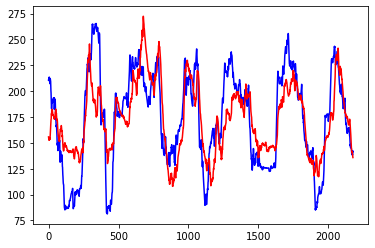

In [37]:
#As an example, I plot an example 3000 values of the x position (column index 0), both true and predicted with the Kalman filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_kf=plt.figure()
plt.plot(y_kf_valid[2000:5000,0]+y_kf_train_mean[0],'b')
plt.plot(y_valid_predicted_kf[2000:5000,0]+y_kf_train_mean[0],'r')
#Save figure
# fig_x_kf.savefig('x_position_decoding.eps')